<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/ML-Sleep-Quality-Based-EEG-Signals/blob/main/3_Sleep_EDF_Ext_ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Systems for Sleep Quality Assessment Based on EEG Signals

---

* **Author**: Carmen-Theodora Craciun
* **Status**: Done
* **The purpose of this Notebook**: This notebook handles *data cleaning, file verification, label mapping*, train/test/val splitting, and distribution analysis.
* **Dataset**: [Sleep-EDFX Database (PhysioNet)](https://www.physionet.org/content/sleep-edfx/1.0.0/)
  * **Studies used:**
    * Sleep Cassette (SC) - the study on healthy people
    * Sleep Telemetry (ST) - study on people diagnosed with mild insomnia.
* **Previos Step**: [Data visualization](https://colab.research.google.com/drive/1cBch3tvJHvTiagYhDABn147fa3gCt9Ud?usp=sharing)
* **Input**:
  * The 4 folders with the EDF files created in the step 1
  * full_paths.csv from step 2.
* **Output:**
  * class_distribution.csv
  * results.zip - a compressed archive containing the layered and prepared dataset for training (train, test, val)
    * each file in these folders represents a *processed sleep window* (epoch)

#Instalation and importing

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 45.1 MB/s eta 0:00:00


In [14]:
import os
# import gc
import csv
import mne
# import h5py
# import json
import shutil
# import logging
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import resample
from sklearn.model_selection import train_test_split

mne.set_log_level('ERROR') # MNE will show only the errors
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/sleep_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Extract

In [6]:
all_df = pd.read_csv(base_path + '/full_paths.csv')
print(f"The number of healthy results is: {len(all_df[all_df['study'] == 'SC (healthy)'])}")
print(f"The number of insomnia results is: {len(all_df[all_df['study'] == 'ST (insomnia)'])}")

The number of healthy results is: 153
The number of insomnia results is: 44


In [7]:
all_df

,id,psg_path,hypno_path,study
0,SC4001,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,SC (healthy)
1,SC4002,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,SC (healthy)
2,SC4011,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,SC (healthy)
3,SC4012,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,SC (healthy)
4,SC4021,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,SC (healthy)
...,...,...,...,...
192,ST7212,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,ST (insomnia)
193,ST7221,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,ST (insomnia)
194,ST7222,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,ST (insomnia)
195,ST7241,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,ST (insomnia)


#Transform

##Quality checking

In [8]:
class SleepDataQuality:
    '''This class is responsible for validating the integrity of raw files.'''
    def __init__(self, df):
        self.df = df.copy()

    def __check_hypno_quality(self, row):
        '''Checks the validity of the hypnogram file, reads the annotations using MNE and calculates the sleep stage distribution.

        Parameters:
          - row (pd.Series) - A row in the DataFrame containing the path to the hypnogram file.

         Returns:
          - pd.Series - Contains the validation status ('OK', 'Missing', 'Empty', etc.) and the number of epochs for each sleep stage.
        '''
        file_path = row['hypno_path']
        # Define the result structure, including N4 and hypno_error
        result = {
            'hypno_status': 'Unknown',
            'hypno_duration': 0,
            'n_epochs': 0,
            'W': 0, 'N1': 0, 'N2': 0, 'N3': 0, 'N4': 0, 'REM': 0, 'Unknown': 0,
            'hypno_error': ''  # New column for errors
        }

        # Updated mapping: Stage 4 -> N4
        stage_map = {
            'Sleep stage W': 'W', 'W': 'W',
            'Sleep stage 1': 'N1', '1': 'N1',
            'Sleep stage 2': 'N2', '2': 'N2',
            'Sleep stage 3': 'N3', '3': 'N3',
            'Sleep stage 4': 'N4', '4': 'N4',    # Explicitly map N4
            'Sleep stage R': 'REM', 'R': 'REM',
            'Movement time': 'Unknown', 'Sleep stage ?': 'Unknown'
        }

        # 1. Check physical existence
        if not os.path.exists(file_path):
             result['hypno_status'] = 'Missing_File'
             result['hypno_error'] = 'File path does not exist'
             return pd.Series(result)

        try:
            # 2. Read with MNE
            annot = mne.read_annotations(file_path)

            if len(annot) == 0 or annot.duration.sum() == 0:
                result['hypno_status'] = 'Empty_Annotations'
                result['hypno_error'] = 'File contains 0 annotations'
                return pd.Series(result)

            result['hypno_status'] = 'OK'
            result['hypno_duration'] = annot.duration.sum()

            for desc, dur in zip(annot.description, annot.duration):
                n_30s_chunks = int(dur // 30)
                stage = stage_map.get(desc, 'Unknown')

                if stage in result:
                    result[stage] += n_30s_chunks
                    result['n_epochs'] += n_30s_chunks

            return pd.Series(result)

        except Exception as e:
            # Capture the exact error from MNE
            result['hypno_status'] = 'Read_Error'
            result['hypno_error'] = str(e)

        # Fallback for 0-byte files that don’t raise exceptions but are empty
        try:
            if os.path.getsize(file_path) == 0:
                result['hypno_status'] = 'Empty_File_0B'
                result['hypno_error'] = 'File size is 0 bytes'
        except:
            pass

        return pd.Series(result)

    def __check_psg_quality(self, row):
        '''=Ensures that the required channels (EEG, EMG, EOG) are present and that the recording duration is valid.

        Parameters:
          - row (pd.Series) - A row in the DataFrame containing the path to the PSG file.

         Returns:
          - pd.Series - Contains the status, duration in seconds, number of channels and any errors found.
        '''
        path = row['psg_path']
        result = {
            'psg_status': 'Unknown',
            'psg_duration': 0,
            'psg_ch_count': 0,
            'psg_error': ''
        }

        # Required channels
        required_channels = [
            'EEG Fpz-Cz',
            'EEG Pz-Oz',
            'EMG submental',
            'EOG horizontal'
        ]
        # Marker is checked separately (can be "Marker" or "Event marker")

        if not os.path.exists(path):
            result['psg_status'] = 'Missing_File'
            result['psg_error'] = 'File path does not exist'
            return pd.Series(result)

        try:
            # Read only the header
            raw = mne.io.read_raw_edf(path, preload=False, verbose=False)
            ch_names = raw.ch_names

            # Check required channels
            missing = []
            for req in required_channels:
                if req not in ch_names:
                    missing.append(req)

            # Check Marker (flexible)
            has_marker = any(m in ch_names for m in ['Marker', 'Event marker'])
            if not has_marker:
                missing.append('Marker')

            result['psg_duration'] = raw.times[-1]
            result['psg_ch_count'] = len(ch_names)

            if missing:
                result['psg_status'] = 'Missing_Channels'
                result['psg_error'] = f"Missing: {', '.join(missing)}"
            elif result['psg_duration'] < 3600:
                result['psg_status'] = 'Too_Short'
                result['psg_error'] = f"Duration {result['psg_duration']/3600:.1f}h < 1h"
            else:
                result['psg_status'] = 'OK'

        except Exception as e:
            result['psg_status'] = 'Read_Error'
            result['psg_error'] = str(e)

        return pd.Series(result)

    def _run_validation(self):
        '''The main method that orchestrates the validation process. Applies the hypnogram and PSG checks to the entire dataset.

        Returns:
          - pd.DataFrame - the original DataFrame concatenated with the generated quality statistics.
        '''

        print("Checking Hypnograms")
        hypno_stats = self.df.apply(self.__check_hypno_quality, axis=1)
        print("Done checking the hypnograms\n")

        print("Checking PSG files")
        psg_stats = self.df.apply(self.__check_psg_quality, axis=1)
        print("Done checking the PSG files")

        final_df = pd.concat([self.df, hypno_stats, psg_stats], axis=1)
        self.__print_summary(final_df)
        return final_df

    def __print_summary(self, df):
        '''Displays a summary report of the validation process, highlighting files that failed checks (missing, corrupt, or 0-time files).'''
        print("\n=== VALIDATION SUMMARY ===")
        print(f"Total Files: {len(df)}")
        print("The new dataframe looks like this:")
        display(df.head(1))

        print("\nErrors found:")
        error_hypno = df[((df['hypno_status'] != 'OK') |
                         (df['hypno_duration'] == 0)) |
                         (df['hypno_error'] != '')]
        if len(error_hypno):
            print("At hypnograms")
            display(error_hypno)
        else:
            print("No errors at hypnograms")

        error_psg = df[((df['psg_status'] != 'OK') |
                        (df['psg_duration'] == 0) |
                        (df['psg_error'] != '') )]
        if len(error_psg):
            print("At PSG files")
            display(error_psg)
        else:
            print("No errors at PSG files")


validator = SleepDataQuality(all_df)
validated_df = validator._run_validation()

# Deliting variabiles not used anymore
del all_df
del validator

Checking Hypnograms
Done checking the hypnograms

Checking PSG files
Done checking the PSG files

=== VALIDATION SUMMARY ===
Total Files: 197
The new dataframe looks like this:


,id,psg_path,hypno_path,study,hypno_status,hypno_duration,n_epochs,W,N1,N2,N3,N4,REM,Unknown,hypno_error,psg_status,psg_duration,psg_ch_count,psg_error
0,SC4001,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,SC (healthy),OK,86400.0,2880,1997,58,250,101,119,125,230,,OK,79499.99,7,



Errors found:
No errors at hypnograms
No errors at PSG files


In [9]:
validated_df.drop(columns=['hypno_status', 'hypno_error','psg_status','psg_error'], inplace=True)
validated_df.head(5)

,id,psg_path,hypno_path,study,hypno_duration,n_epochs,W,N1,N2,N3,N4,REM,Unknown,psg_duration,psg_ch_count
0,SC4001,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,SC (healthy),86400.0,2880,1997,58,250,101,119,125,230,79499.99,7
1,SC4002,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,SC (healthy),86400.0,2880,1885,59,373,94,203,215,51,84899.99,7
2,SC4011,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,SC (healthy),86400.0,2880,1856,109,562,96,9,170,78,84059.99,7
3,SC4012,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,SC (healthy),86400.0,2880,1824,92,660,80,16,176,32,85499.99,7
4,SC4021,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,SC (healthy),86400.0,2880,1907,94,545,73,22,163,76,84119.99,7


##Label Mapping & Epoch Segmentation

In [12]:
class LabelMapping:
    '''Handles the process for signals. It loads raw signals, filters them, divides them into epochs (time windows),
    and associates them with standardized sleep labels, saving the result in .npz format.'''
    def __init__(self, output_dir='/content/results', sfreq=100, epoch_sec=30):
        self.output_dir = output_dir
        self.sfreq = sfreq
        self.epoch_sec = epoch_sec
        self.target_channels = ['EEG Fpz-Cz', 'EEG Pz-Oz']

    def __get_annotation_map(self):
        '''Returns the standard mapping dictionary according to AASM (American Academy of Sleep Medicine).'''
        return {
            'Sleep stage W': 0,
            'Sleep stage 1': 1,
            'Sleep stage 2': 2,
            'Sleep stage 3': 3,  # N3
            'Sleep stage 4': 3,  # N4 becomes N3 (Standard AASM)
            'Sleep stage R': 4
        }

    def __load_and_clean_psg(self, psg_path):
        '''Loads the EDF file, selects the channels of interest (Fpz-Cz, Pz-Oz),
        resamples to the desired frequency and applies a Bandpass filter (0.3Hz - 35Hz).

        Parameters:
          - psg_path (str) - Path to the PSG file.

        Returns:
          - `mne.io.Raw` - The preprocessed raw object.
        '''
        # 1. Load
        raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)

        # 2. Check channels
        if not all(ch in raw.ch_names for ch in self.target_channels):
            raise ValueError(f"Missing required channels. Found: {raw.ch_names}")

        # 3. Select channels
        raw.pick_channels(self.target_channels)

        # 4. Resampling
        if raw.info['sfreq'] != self.sfreq:
            raw.resample(self.sfreq)

        # 5. Bandpass Filtering (0.3Hz - 35Hz)
        raw.filter(l_freq=0.3, h_freq=35.0, verbose=False)

        return raw

    def __extract_events(self, raw, hypno_path):
        '''Reads annotations from the hypnogram and synchronizes them with the raw signal to create discrete events.

        Parameters:
          - raw (mne.io.Raw) - The preprocessed raw object.
          - hypno_path (str) - Path to the hypnogram file.

        Returns:
          - tuple - A list of events and the ID mapping dictionary.
        '''
        annot = mne.read_annotations(hypno_path)
        raw.set_annotations(annot, emit_warning=False)

        mapping = self.__get_annotation_map()

        events, _ = mne.events_from_annotations(
            raw,
            event_id=mapping,
            chunk_duration=self.epoch_sec, # Split long stages
            verbose=False
        )
        return events, mapping

    def __create_epochs(self, raw, events, event_id):
        '''Segments the continuous signal into fixed windows (epochs) of 30 seconds based on the extracted events.

        Parameters:
          - raw (mne.io.Raw): contain the continuous data.
          - events (numpy.ndarray): array  generated by annotations.
          - event_id (dict): a dictionary that maps the stage names to the numeric values.

        Returns:
          - mne.Epochs - stores the segmented data in a 3D structure (n_epochs, n_channels, n_time), ready to be converted to a NumPy array.
        '''
        tmax = self.epoch_sec - 1. / raw.info['sfreq']

        epochs = mne.Epochs(
            raw,
            events,
            event_id=event_id,
            tmin=0., tmax=tmax,
            baseline=None,
            preload=True,
            verbose=False,
            on_missing='ignore' # Ignore stages that may be missing from a file
        )
        return epochs

    def __save_data(self, subject_id, epochs):
        '''Extracts the numeric data from the epochs, converts the unit of measurement to microvolts, and saves the compressed files to disk.

        Parameters:
          - subject_id (str)
          - epochs (mne.Epochs) - contains the already segmented EEG signal windows

        Returns:
          - tuple - The dimensions of the saved arrays (shape X, shape y).
        '''
        # X: (n_epochs, n_channels, n_samples)
        # Multiply by 1e6 (10^6) to convert to microvolts
        X = epochs.get_data() * 1e6

        # y: (n_epochs,) - labels (0-4)
        y = epochs.events[:, 2]

        save_path = os.path.join(self.output_dir, f"{subject_id}.npz")
        np.savez_compressed(save_path, x=X, y=y)

        return X.shape, y.shape

    def __process_single_subject(self, row):
        '''Wrapper function that executes the pipeline for a single subject.'''
        subject_id = row['id']

        # Caching: If it already exists, skip
        if os.path.exists(os.path.join(self.output_dir, f"{subject_id}.npz")):
            return "Skipped (Exists)"

        try:
            # 1. Signal Processing
            raw = self.__load_and_clean_psg(row['psg_path'])

            # 2. Extract Events (Mapping)
            events, event_map = self.__extract_events(raw, row['hypno_path'])

            # 3. Windowing
            epochs = self.__create_epochs(raw, events, event_map)

            # 4. Save
            x_shape, y_shape = self.__save_data(subject_id, epochs)

            return f"Success {x_shape}"

        except Exception as e:
            return f"Error: {str(e)}"

    def run(self, df):
        '''Iterates through the list of validated files and processes each subject, reporting the progress.'''
        # Filter only files previously marked as valid
        print("Start labeling")
        results = []
        total_files = len(df)

        for i, (index, row) in enumerate(df.iterrows()):
            status = self.__process_single_subject(row)
            results.append({'id': row['id'], 'etl_status': status})

            # Print errors immediately so we can see them
            if "Error" in status:
                print(f"Error: {row['id']}: {status}")

            if (i + 1) % 10 == 0 or (i + 1) == total_files:
                print(f"Progress: {i + 1}/{total_files} files processed...")

        print("\nPipeline Finished.")
        return pd.DataFrame(results)

!rm -rf /content/results
!mkdir -p /content/results
label = LabelMapping()
label_results_df = label.run(validated_df)

print("Look for errors:")
label_results_df[~label_results_df['etl_status'].str.contains('Success')]

del label
del label_results_df

Start labeling
Progress: 10/197 files processed...
Progress: 20/197 files processed...
Progress: 30/197 files processed...
Progress: 40/197 files processed...
Progress: 50/197 files processed...
Progress: 60/197 files processed...
Progress: 70/197 files processed...
Progress: 80/197 files processed...
Progress: 90/197 files processed...
Progress: 100/197 files processed...
Progress: 110/197 files processed...
Progress: 120/197 files processed...
Progress: 130/197 files processed...
Progress: 140/197 files processed...
Progress: 150/197 files processed...
Progress: 160/197 files processed...
Progress: 170/197 files processed...
Progress: 180/197 files processed...
Progress: 190/197 files processed...
Progress: 197/197 files processed...

Pipeline Finished.
Look for errors:


##Data distribution anlysis



We recall here the problem observed in the data visualization step:

> === COMPARISON HEALTHY (SC) vs INSOMNIA (ST) ===
>
> Duration:
>
> Healthy (SC): 153 files
>   * Mean: 22.68 h
>   * Min-Max: 17.00 - 24.00 h
>
> Insomnia (ST): 37 files
>   * Mean: 8.76 h
>   * Min-Max: 7.63 - 10.70 h
>
> Average difference: 13.92 h (Healthy (SC) - Insomnia (ST))

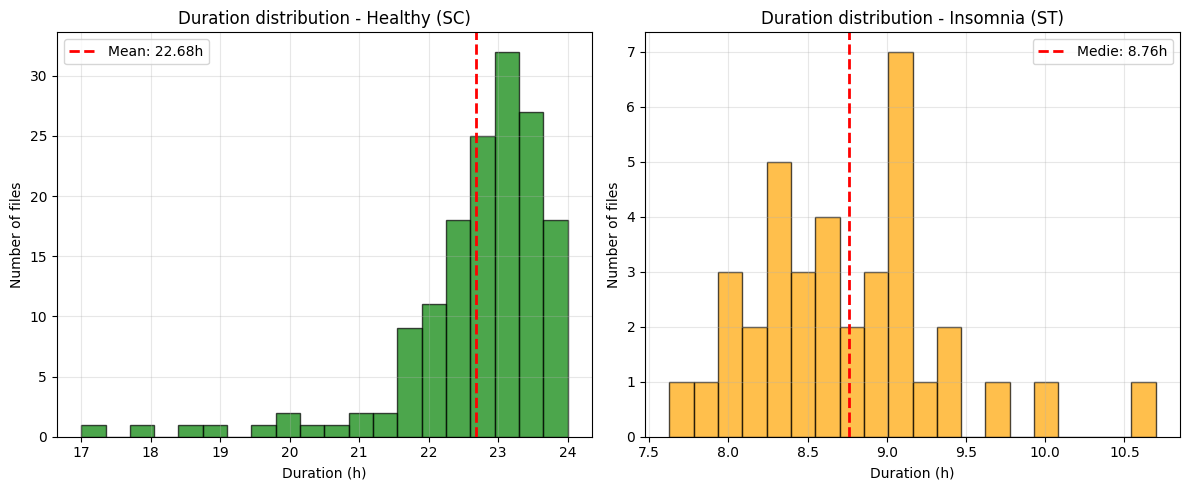

The SC study has too much recording time, automatically has too much Wake for our problem. We will have to cut out the moments when he is not actually sleeping.

Starting Crop Job on 197 files...
Crop progress: 10/197 files...
Crop progress: 20/197 files...
Crop progress: 30/197 files...
Crop progress: 40/197 files...
Crop progress: 50/197 files...
Crop progress: 60/197 files...
Crop progress: 70/197 files...
Crop progress: 80/197 files...
Crop progress: 90/197 files...
Crop progress: 100/197 files...
Crop progress: 110/197 files...
Crop progress: 120/197 files...
Crop progress: 130/197 files...
Crop progress: 140/197 files...
Crop progress: 150/197 files...
Crop progress: 160/197 files...
Crop progress: 170/197 files...
Crop progress: 180/197 files...
Crop progress: 190/197 files...
Crop progress: 197/197 files...
=== SUMMARY ===
Stats processed: 20/197 files...
Stats processed: 40/197 files...
Stats processed: 60/197 files...
Stats processed: 80/197 files...
Stats processed: 100/197 files...
Stats processed: 120/197 files...
Stats processed: 140/197 files...
Stats processed: 160/197 files...
Stats processed: 180/197 files...
Stats processed: 

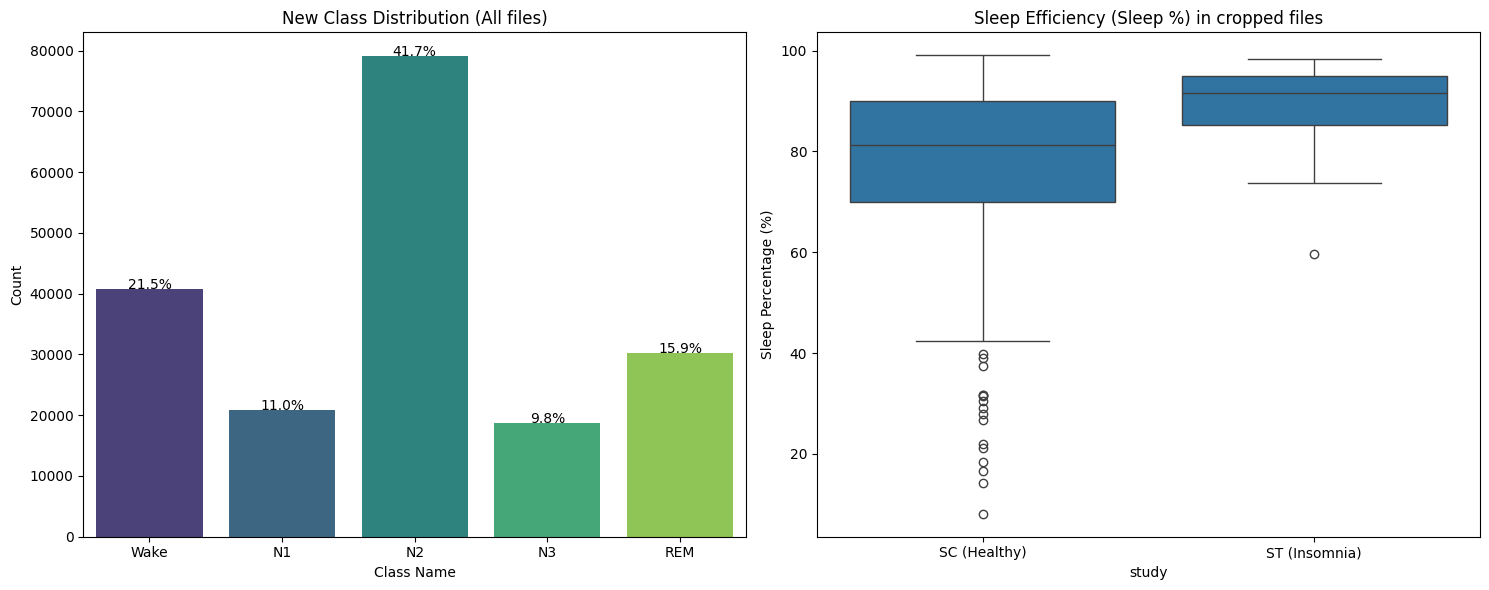

status
Cropped         153
Skipped (ST)     44
Name: count, dtype: int64
Number of files cropped is 153


In [15]:
class SleepCropper:
    '''Handles post-processing of the data to balance the classes. Identifies the onset of sleep and crops the excess
    "Wake" state from the beginning and end of the recordings for healthy subjects.'''
    def __init__(self, data_dir='/content/results', target_hours=8, sfreq=100):
        self.data_dir = data_dir
        self.target_hours = target_hours
        self.sfreq = sfreq
        self.epochs_for_target = int(target_hours * 3600 / 30) # 960 epochs for 8 hours

    def __find_sleep_onset(self, y_labels, min_consecutive=5):
        '''Detects the index where actual sleep begins, searching for a consecutive sequence of non-Wake epochs.
        The first sequence of 'min_consecutive' epochs that are NOT Wake (0).

        Parameters:
          - y_labels (array)
          - min_consecutive (int) - Minimum number of consecutive sleep epochs required.

        Returns:
          - int - The starting index.
        '''
        consecutive_sleep = 0

        for i, label in enumerate(y_labels):
            if label != 0:  # 0 is Wake
                consecutive_sleep += 1
                if consecutive_sleep >= min_consecutive:
                    # Return the start index of the sequence
                    return max(0, i - min_consecutive + 1)
            else:
                consecutive_sleep = 0

        return 0 # Fallback: if no sleep is found, start from 0

    def __crop_file(self, file_path, study_type):
        '''Loads the .npz file, calculates the relevant interval (onset + 8 hours) and overwrites the file with the truncated data. Applies to 'SC' (Healthy) studies only.

        Parameters:
          - file_path (str)
          - study_type (str).

        Returns:
          - dict - Statistics about the crop operation (original vs. new length).
        '''
        try:
            data = np.load(file_path)
            X = data['x']
            y = data['y']

            if study_type == 'SC (healthy)':

                # 1. Find Onset
                onset_idx = self.__find_sleep_onset(y)

                # 2. Calculate Offset (Onset + 8 hours)
                end_idx = onset_idx + self.epochs_for_target

                # Make sure not to exceed the total length
                if end_idx > len(y):
                    end_idx = len(y)

                # If the segment is too short (< 4 hours), it may be an error, but crop anyway

                # 3. Apply Crop
                X_cropped = X[onset_idx:end_idx]
                y_cropped = y[onset_idx:end_idx]

                # 4. Overwrite
                np.savez_compressed(file_path, x=X_cropped, y=y_cropped)

                return {
                    'status': 'Cropped',
                    'original_len': len(y),
                    'new_len': len(y_cropped),
                    'onset': onset_idx
                }

            else:
                return {'status': 'Skipped (ST)', 'new_len': len(y)}

        except Exception as e:
            return {'status': f'Error: {str(e)}'}

    def __verify_dataset_balance(self):
        '''Analyzes the distribution of classes in the new processed dataset and generates graphs to visualize balance and sleep efficiency.

        Returns:
          - pd.DataFrame - Detailed statistics about the distribution of classes.
        '''
        print(f"=== SUMMARY ===")

        files = [f for f in os.listdir(self.data_dir) if f.endswith('.npz')]
        total_files = len(files)

        # Containers for statistics
        all_labels = []
        file_stats = []

        for i, filename in enumerate(files):
            try:
                filepath = os.path.join(self.data_dir, filename)
                data = np.load(filepath)
                y = data['y']

                # Collect all labels for the global distribution
                all_labels.extend(y)

                # Statistics per file
                unique, counts = np.unique(y, return_counts=True)
                dist = dict(zip(unique, counts))

                # Calculate "Sleep Efficiency" (approximate) for this segment
                # 0 = Wake. Everything else is sleep.
                total_epochs = len(y)
                wake_epochs = dist.get(0, 0)
                sleep_epochs = total_epochs - wake_epochs
                sleep_eff = (sleep_epochs / total_epochs) * 100 if total_epochs > 0 else 0

                study_type = 'SC (Healthy)' if 'SC' in filename else 'ST (Insomnia)'

                file_stats.append({
                    'filename': filename,
                    'study': study_type,
                    'total_epochs': total_epochs,
                    'wake_pct': (wake_epochs/total_epochs)*100,
                    'sleep_eff': sleep_eff
                })

            except Exception as e:
                print(f"Error at {filename}: {e}")

            if (i + 1) % 20 == 0 or (i + 1) == total_files:
                print(f"Stats processed: {i + 1}/{total_files} files...")

        # --- 1. Global Class Distribution ---
        print("\n--- GLOBAL CLASS DISTRIBUTION ---")
        unique_all, counts_all = np.unique(all_labels, return_counts=True)
        total_samples = len(all_labels)

        # Reverse mapping for clarity (0-4)
        class_names = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}

        stats_df = pd.DataFrame({
            'Class ID': unique_all,
            'Class Name': [class_names.get(i, 'Unknown') for i in unique_all],
            'Count': counts_all,
            'Percentage': (counts_all / total_samples) * 100
        })

        print(stats_df.to_string(index=False))

        # Check Imbalance Ratio
        max_cls = stats_df['Count'].max()
        min_cls = stats_df['Count'].min()
        ratio = max_cls / min_cls
        print(f"\nImbalance Ratio (Max/Min): {ratio:.2f}:1")
        if ratio < 10:
            print("Status: ACCEPTABLE")
        else:
            print("Status: Still imbalanced")

        # --- 2. Visualization ---
        df_files = pd.DataFrame(file_stats)

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Barplot Classes
        sns.barplot(data=stats_df, x='Class Name', y='Count', ax=axes[0], palette='viridis', hue='Class Name', legend=False)
        axes[0].set_title('New Class Distribution (All files)')
        for index, row in stats_df.iterrows():
            axes[0].text(index, row.Count, f'{row.Percentage:.1f}%', color='black', ha="center")

        # Boxplot Sleep Efficiency SC vs ST
        sns.boxplot(data=df_files, x='study', y='sleep_eff', ax=axes[1])
        axes[1].set_title('Sleep Efficiency (Sleep %) in cropped files')
        axes[1].set_ylabel('Sleep Percentage (%)')

        plt.tight_layout()
        plt.show()

        return stats_df

    def run(self, df):
        '''Executes the crop logic for all files in the DataFrame and finally runs the data balance check.'''
        total_files = len(df)
        print(f"Starting Crop Job on {total_files} files...")
        results = []

        for i, (idx, row) in enumerate(df.iterrows()):
            subject_id = row['id']
            study_type = row['study']

            file_path = os.path.join(self.data_dir, f"{subject_id}.npz")

            if os.path.exists(file_path):
                res = self.__crop_file(file_path, study_type)
                res['id'] = subject_id
                results.append(res)
            else:
                results.append({'id': subject_id, 'status': 'File Not Found'})

            if (i + 1) % 10 == 0 or (i + 1) == total_files:
                  print(f"Crop progress: {i + 1}/{total_files} files...")

        stats_df = self.__verify_dataset_balance()
        return pd.DataFrame(results), stats_df

cropper = SleepCropper(target_hours=8)
crop_results, stats_df = cropper.run(validated_df)
print(crop_results['status'].value_counts())
print(f"Number of files cropped is {len(crop_results[(crop_results['original_len'] != crop_results['new_len']) & (crop_results['status'] == 'Cropped')])}")
stats_df.to_csv(base_path + '/class_distribution.csv', index=False)

del validated_df
del cropper
del crop_results
del stats_df

##Splitting

In [16]:
class StratifiedDatasetSplitter:
    '''Manages the splitting of the dataset into training, validation and testing subsets, ensuring a correct
    stratification between healthy patients (SC) and insomniacs (ST).'''
    def __init__(self, source_dir='/content/results', output_dir=base_path + '/process_dataset', split_ratios=(0.70, 0.15, 0.15), seed=42):
        self.source_dir = source_dir
        self.output_dir = output_dir
        self.split_ratios = split_ratios # Train, Val, Test
        self.seed = seed
        self.subsets = ['train', 'val', 'test']

    def __split_list(self,file_list):
        '''Splits a given list of subject files into training, validation, and testing subsets according to the predefined split ratios.
        The split is performed deterministically using the class-level random seed to ensure reproducibility.

        Parameters:
            file_list (list of str):
                List of filenames belonging to a specific category (e.g., SC or ST).

        Returns:
            tuple:
                - train (list of str): Files assigned to the training subset.
                - val   (list of str): Files assigned to the validation subset.
                - test  (list of str): Files assigned to the testing subset.
        '''
        if not file_list: return [], [], []

        # Compute the sizes
        train_r, val_r, test_r = self.split_ratios

        # Split 1: Train vs (Val+Test)
        test_val_size = val_r + test_r
        train, temp = train_test_split(file_list, test_size=test_val_size, random_state=self.seed, shuffle=True)

        # Split 2: Val vs Test
        relative_test_size = test_r / test_val_size
        val, test = train_test_split(temp, test_size=relative_test_size, random_state=self.seed, shuffle=True)

        return train, val, test

    def run(self):
        '''The method identifies all processed .npz files:
          - separates them into healthy (SC) and insomnia (ST) groups
          - applies the stratified split for each group independently
          - reports the resulting distribution
          - moves the files into their corresponding output directories (train/val/test).
        '''
        print(f"=== STRATIFIED DATASET SPLITTING ===")

        # 1. Identify the files
        all_files = [f for f in os.listdir(self.source_dir) if f.endswith('.npz')]

        # Manually separate them to guarantee stratification
        sc_files = [f for f in all_files if 'SC' in f] # Healthy
        st_files = [f for f in all_files if 'ST' in f] # Insomnia

        print(f"Total Files Found: {len(all_files)}")
        print(f"  - Healthy (SC): {len(sc_files)} files")
        print(f"  - Insomnia (ST): {len(st_files)} files")

        # 2. Perform the split separately
        sc_train, sc_val, sc_test = self.__split_list(sc_files)
        st_train, st_val, st_test = self.__split_list(st_files)

        # 4. Distribution report
        print("\n--- Distribution Report ---")
        print(f"TRAIN: {len(sc_train)} Healthy + {len(st_train)} Insomnia = {len(sc_train)+len(st_train)} files")
        print(f"VAL:   {len(sc_val)} Healthy + {len(st_val)} Insomnia  = {len(sc_val)+len(st_val)} files")
        print(f"TEST:  {len(sc_test)} Healthy + {len(st_test)} Insomnia = {len(sc_test)+len(st_test)} files")

        # 5. Physically move the files
        print("\nMoving files...")

        splits = {
            'train': sc_train + st_train,
            'val':   sc_val + st_val,
            'test':  sc_test + st_test
        }

        for subset_name, files in splits.items():
            target_path = os.path.join(self.output_dir, subset_name)
            os.makedirs(target_path, exist_ok=True)

            for filename in files:
                src = os.path.join(self.source_dir, filename)
                dst = os.path.join(target_path, filename)
                shutil.copy2(src, dst)

        print(f"Done! Data is ready in: {self.output_dir}")

!mkdir base_path + '/process_dataset'
splitter = StratifiedDatasetSplitter()
splitter.run()

del splitter

=== STRATIFIED DATASET SPLITTING ===
Total Files Found: 197
  - Healthy (SC): 153 files
  - Insomnia (ST): 44 files

--- Distribution Report ---
TRAIN: 107 Healthy + 30 Insomnia = 137 files
VAL:   23 Healthy + 7 Insomnia  = 30 files
TEST:  23 Healthy + 7 Insomnia = 30 files

Moving files...
Done! Data is ready in: /content/drive/MyDrive/sleep_data/process_dataset


---
# Conclusions and Next Step

In this notebook we:
1. Extract / **Data Ingestion.** - the process of reading raw files to access to all raw files in an indexed format, without altering their content.

2. Transform
    1.  **Quality Checking**
  Technical Cleanup.** - identification of files that are impossible to use for technical reasons.
  * Resulting in a "clean" list, removing corrupt files, empty files or those that do not contain valid sleep annotations, to prevent errors in the next steps.

    2. **Label Mapping & Epoch Segmentation**
  * Translation of old labels to the modern AASM standard (W, N1, N2, N3, REM).
  * Cutting the continuous signal and hypnograms into fixed time windows in 30 seconds.
  * To transform the variable raw data into a uniform matrix of epochs with numerical labels, ready to enter a neural model.

    3. **Data Distribution Analysis**
  * *Understanding Imbalances.* Statistical analysis of sleep classes.
  * To visualize how often each stage occurs (e.g. W is often majority, N1 is very rare). This dictates the training strategy (whether you need *Class Weights* or *Oversampling* to avoid ignoring rare classes).
  * Results load save in {base_path}/class_distribution.csv.

    4. **Splitting**
  * *Separate Data for Validation.*
  * To ensure an honest evaluation of the model.
  * Splitting was be done **per patient (Subject-level split)**, not per epoch. That is, the epochs of patient X are not allowed to be both training and testing, to avoid *Data Leakage*
  * Restuls load save in {base_path}/process_dataset.

The next step in the project is to start building the model architectures. We will start with [**Bidirectional LSTM**]().